In [ ]:
!wget http://www.cs.cmu.edu/~ark/personas/data/MovieSummaries.tar.gz
!tar -xf MovieSummaries.tar.gz

In [ ]:
!pip install transformers

In [ ]:
import pandas as pd
import nltk
import torch
import matplotlib.pyplot as plt

from operator import itemgetter
from torch.nn.functional import normalize
from transformers import AutoTokenizer, AutoModel

nltk.download('punkt')

In [10]:
# read as dataframe
df_english = pd.read_csv('/content/MovieSummaries/plot_summaries.txt', delimiter = '\t',names=['id','text'])
df_english.info()
df_english = df_english.head(20)

cos = torch.nn.CosineSimilarity(dim = 1)
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
model = AutoModel.from_pretrained('bert-base-uncased')

docs_vectors_dics_list = []
for i in df_english.index:
  doc = df_english['text'][i]
  inputs = tokenizer(doc, return_tensors='pt', truncation=True, max_length=30)
  outputs = model(**inputs)
  docs_vectors_dics_list.append({
      'text': doc,
      'doc-index':i,
      'vector':outputs.pooler_output,
      'similarity':0
      })

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42303 entries, 0 to 42302
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      42303 non-null  int64 
 1   text    42303 non-null  object
dtypes: int64(1), object(1)
memory usage: 661.1+ KB


Enter your query: go
Document index: 13, text: The film is based on the events that happened on the ship Exodus in 1947 as well as events dealing with the founding of the state of Israel in 1948. Nurse Katherine "Kitty" Fremont  is an American volunteer at the Karaolos internment camp on Cyprus, where thousands of Jews - Holocaust survivors - are being held by the British, who won't let them go to Palestine. They anxiously wait for the day they will be liberated. Ari Ben Canaan , a Hagannah rebel who previously was a captain in the Jewish Brigade of the British Army in the Second World War, obtains a cargo ship and smuggles 611 Jewish inmates out of the camp for an illegal voyage to Mandate Palestine before being discovered by military authorities. When the British find out that the refugees are in a ship in the harbor of Famagusta, they blockade it. The refugees stage a hunger strike, during which the camp's doctor dies, and Ari threatens to blow up the ship and the refugees. The Brit

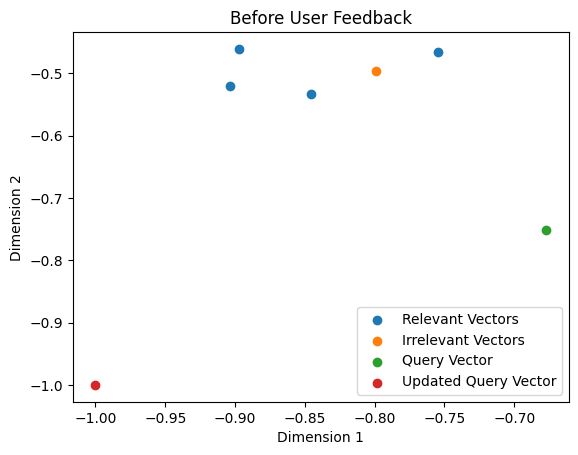

Document index: 13, text: The film is based on the events that happened on the ship Exodus in 1947 as well as events dealing with the founding of the state of Israel in 1948. Nurse Katherine "Kitty" Fremont  is an American volunteer at the Karaolos internment camp on Cyprus, where thousands of Jews - Holocaust survivors - are being held by the British, who won't let them go to Palestine. They anxiously wait for the day they will be liberated. Ari Ben Canaan , a Hagannah rebel who previously was a captain in the Jewish Brigade of the British Army in the Second World War, obtains a cargo ship and smuggles 611 Jewish inmates out of the camp for an illegal voyage to Mandate Palestine before being discovered by military authorities. When the British find out that the refugees are in a ship in the harbor of Famagusta, they blockade it. The refugees stage a hunger strike, during which the camp's doctor dies, and Ari threatens to blow up the ship and the refugees. The British relent and allow 

In [ ]:
while(True):
    rel_docs_vectors_dics_list = []
    irrel_docs_vectors_dics_list = []
    feedback = []

    query = input('Enter your query: ')
    inputs = tokenizer(query, return_tensors='pt')
    outputs = model(**inputs)
    query_vector = outputs.pooler_output
    query_vector = normalize(query_vector, 2, 0)

    for dic in docs_vectors_dics_list:
        dic['similarity'] = cos(dic['vector'], query_vector)

    newlist = sorted(docs_vectors_dics_list, key=itemgetter('similarity'), reverse=True)

    counter = 0
    last_index = []

    for dic in newlist:
        if (not dic['doc-index'] in last_index) and counter < 5:
            last_index.append(dic['doc-index'])
            index = dic['doc-index']
            print(f"Document index: {index}, text: {dic['text']}, Similarity score: {dic['similarity'].item():.2f}")
            is_relevant = input('Enter 1 for relevant and -1 for non-relevant: ')
            feedback.append(int(is_relevant))
            if int(is_relevant) == 1:
                rel_docs_vectors_dics_list.append(dic)
            elif int(is_relevant) == -1:
                irrel_docs_vectors_dics_list.append(dic)
            counter += 1

    alpha = 1.5
    beta = 2

    updated_query_vector = query_vector

    if len(rel_docs_vectors_dics_list) > 0:
        rel_vectors = [doc['vector'] for doc in rel_docs_vectors_dics_list]
        mean_rel_vector = torch.mean(torch.stack(rel_vectors), dim=0)
        updated_query_vector += alpha * mean_rel_vector

    if len(irrel_docs_vectors_dics_list) > 0:
        irrel_vectors = [doc['vector'] for doc in irrel_docs_vectors_dics_list]
        mean_irrel_vector = torch.mean(torch.stack(irrel_vectors), dim=0)
        updated_query_vector -= beta * mean_irrel_vector

    updated_query_vector = normalize(updated_query_vector, 2, 0)

    # convert vectors to numpy arrays
    if(len(rel_docs_vectors_dics_list) > 0 ):
      r_doc_vectors_np = torch.stack([doc['vector'].squeeze() for doc in rel_docs_vectors_dics_list]).detach().numpy()
    if(len(irrel_docs_vectors_dics_list) > 0):
      ir_doc_vectors_np = torch.stack([doc['vector'].squeeze() for doc in irrel_docs_vectors_dics_list]).detach().numpy()
    query_vector_np = query_vector.squeeze().detach().numpy()
    updated_query_vector_np = updated_query_vector.squeeze().detach().numpy()

    # create a scatter plot before user feedback
    fig, ax = plt.subplots()
    ax.scatter(r_doc_vectors_np[:, 0], r_doc_vectors_np[:, 1], label='Relevant Vectors')
    ax.scatter(ir_doc_vectors_np[:, 0], ir_doc_vectors_np[:, 1], label='Irrelevant Vectors')
    ax.scatter(query_vector_np[0], query_vector_np[1], label='Query Vector')
    ax.scatter(updated_query_vector_np[0], updated_query_vector_np[1], label='Updated Query Vector')
    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')
    ax.legend()
    plt.title('Before User Feedback')
    plt.show()

    for dic in docs_vectors_dics_list:
        dic['similarity'] = cos(dic['vector'], updated_query_vector)

    newlist = sorted(docs_vectors_dics_list, key=itemgetter('similarity'), reverse=True)

    counter = 0
    last_index = []

    for dic in newlist:
        if not dic['doc-index'] in last_index and counter < 5:
          last_index.append(dic['doc-index'])
          index = dic['doc-index']
          print(f"Document index: {index}, text: {dic['text']}, Similarity score: {dic['similarity'].item():.2f}")
          counter += 1

    for dic in docs_vectors_dics_list:
        dic['similarity'] = 0